In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [3]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [4]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [5]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [6]:
# Split the data into train, val, test (70-20-10)

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[0:int(n*0.6)]
val_df1 = first_piece[int(n*0.6):int(n*0.8)]
test_df1 = first_piece[int(n*0.8):]


In [7]:
# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1
test_df1 = (test_df1 - train_mean1) / train_std1

In [8]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])   # Sequence of `seq_length`
        targets.append(data[i+seq_length])       # Next value as target
    
    return np.array(sequences), np.array(targets)

In [9]:
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)
val_seq1, val_labels1 = create_sequences(val_df1.values, 12)
test_seq1, test_labels1 = create_sequences(test_df1.values, 12)

In [10]:
# Convert to PyTorch tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1)  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1) # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1)  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1)  # (batch, output_dim)
test_seq_tensor1 = torch.FloatTensor(test_seq1)  # (batch, seq_length, input_dim)
test_labels_tensor1 = torch.FloatTensor(test_labels1)  # (batch, output_dim)

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to("cpu")  # Use "cuda" if you have a GPU


In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.01)

In [13]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model1.train()
    
    optimizer.zero_grad()
    y_pred = model1(train_seq_tensor1)
    
    loss = criterion(y_pred, train_label_tensor1)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Validation
    model1.eval()
    with torch.no_grad():
        y_val = model1(val_seq_tensor1)
        val_loss = criterion(y_val, val_label_tensor1)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 1.011228322982788, Val Loss: 4.600311756134033
Epoch 10, Train Loss: 0.08658266812562943, Val Loss: 2.3588571548461914
Epoch 20, Train Loss: 0.03324166312813759, Val Loss: 0.953764021396637
Epoch 30, Train Loss: 0.020844778046011925, Val Loss: 0.4382554888725281
Epoch 40, Train Loss: 0.014599848538637161, Val Loss: 0.2220563143491745
Epoch 50, Train Loss: 0.01402472984045744, Val Loss: 0.14364482462406158
Epoch 60, Train Loss: 0.01342970784753561, Val Loss: 0.13424159586429596
Epoch 70, Train Loss: 0.012898271903395653, Val Loss: 0.10196929425001144
Epoch 80, Train Loss: 0.01255130860954523, Val Loss: 0.10330323874950409
Epoch 90, Train Loss: 0.012221387587487698, Val Loss: 0.09206181019544601


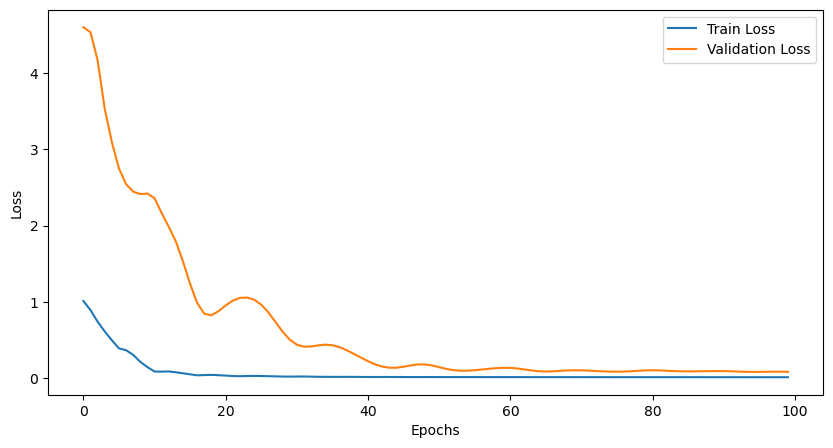

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


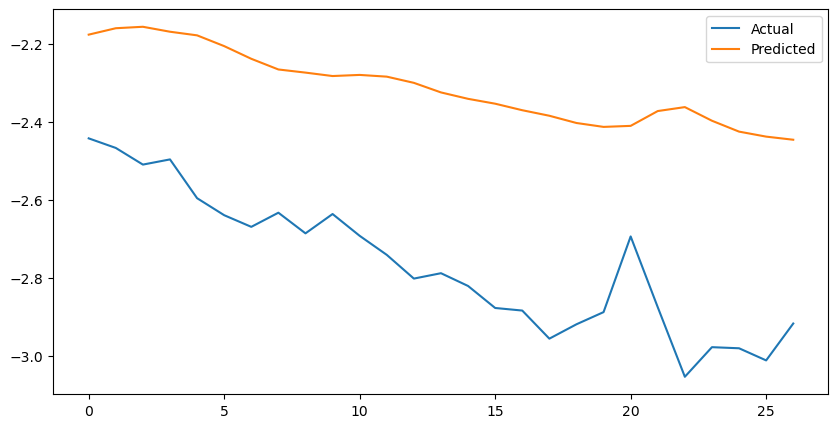

In [15]:
model1.eval()
with torch.no_grad():
    y_pred_test = model1(test_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor1.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()


In [16]:
mae = criterion(y_pred_test, test_labels_tensor1)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.2151530534029007


In [17]:
test_seq_tensor1.shape

torch.Size([27, 12, 1])

In [18]:
np.concatenate((train_df1, val_df1, test_df1), axis=0).shape

(193, 1)

In [19]:
zeros = np.zeros((166,1))

In [20]:
y_pred_test.numpy().shape

(27, 1)

In [21]:
np.concatenate((zeros, y_pred_test.numpy()), axis=0)

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0

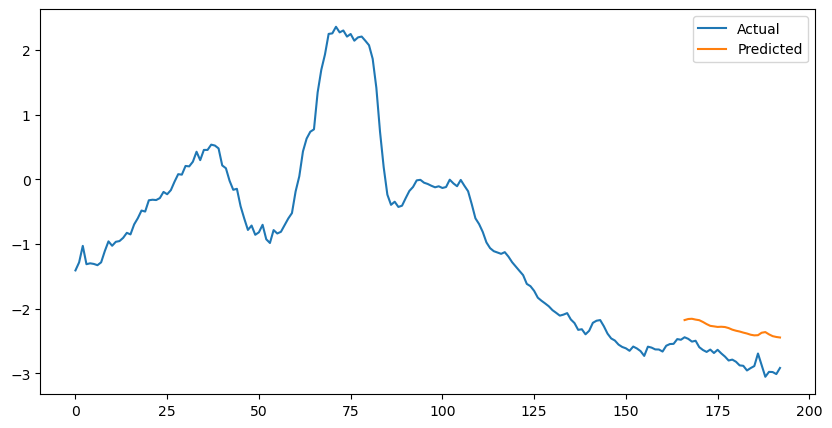

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(np.concatenate((train_df1, val_df1, test_df1), axis=0), label="Actual")
plt.plot(range(166, 193), y_pred_test.numpy(),label="Predicted")
plt.legend()
plt.show()

In [23]:
column_indices = {name: i for i, name in enumerate(second_piece.columns)}
n = len(second_piece)
train_df2 =second_piece[0:int(n*0.6)]
val_df2 = second_piece[int(n*0.6):int(n*0.8)]
test_df2 = second_piece[int(n*0.8):]

In [24]:
# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
val_df2 = (val_df2 - train_mean2) / train_std2
test_df2 = (test_df2 - train_mean2) / train_std2

In [25]:
train_seq2, train_labels2 = create_sequences(train_df2.values, 12)
val_seq2, val_labels2 = create_sequences(val_df2.values, 12)
test_seq2, test_labels2 = create_sequences(test_df2.values, 12)
# Convert to PyTorch tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2)  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2) # (batch, output_dim)
val_seq_tensor2 = torch.FloatTensor(val_seq2)  # (batch, seq_length, input_dim)
val_label_tensor2 = torch.FloatTensor(val_labels2)  # (batch, output_dim)
test_seq_tensor2 = torch.FloatTensor(test_seq2)  # (batch, seq_length, input_dim)
test_labels_tensor2 = torch.FloatTensor(test_labels2)  # (batch, output_dim)

In [26]:
# Model parameters
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1

# Instantiate model
model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model2 = model2.to("cpu")  # Use "cuda" if you have a GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.01)

In [27]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model2.train()
    
    optimizer.zero_grad()
    y_pred = model2(train_seq_tensor2)
    
    loss = criterion(y_pred, train_label_tensor2)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Validation
    model2.eval()
    with torch.no_grad():
        y_val = model2(val_seq_tensor2)
        val_loss = criterion(y_val, val_label_tensor2)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.9226367473602295, Val Loss: 3.338879108428955
Epoch 10, Train Loss: 0.19818317890167236, Val Loss: 1.032305359840393
Epoch 20, Train Loss: 0.05011305212974548, Val Loss: 0.6159476041793823
Epoch 30, Train Loss: 0.03832325339317322, Val Loss: 0.1106976717710495
Epoch 40, Train Loss: 0.029326491057872772, Val Loss: 0.11150714755058289
Epoch 50, Train Loss: 0.027367716655135155, Val Loss: 0.07250303030014038
Epoch 60, Train Loss: 0.024890640750527382, Val Loss: 0.054671868681907654
Epoch 70, Train Loss: 0.023331524804234505, Val Loss: 0.034268055111169815
Epoch 80, Train Loss: 0.021803583949804306, Val Loss: 0.041034191846847534
Epoch 90, Train Loss: 0.02030300721526146, Val Loss: 0.05306027829647064


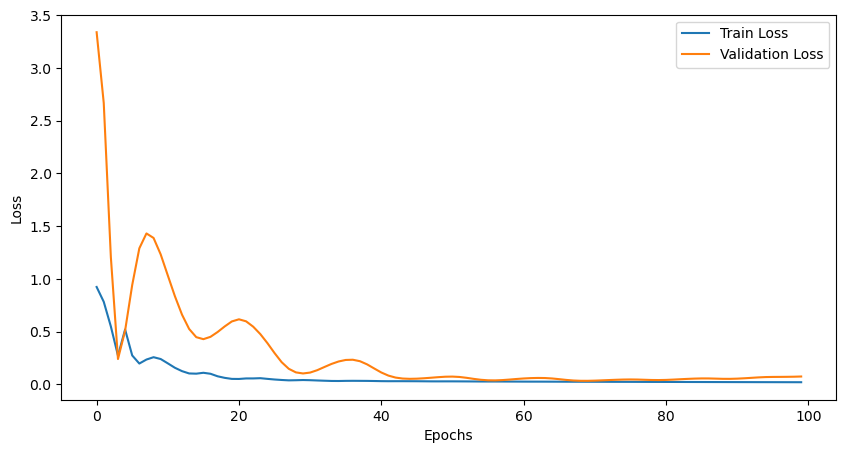

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


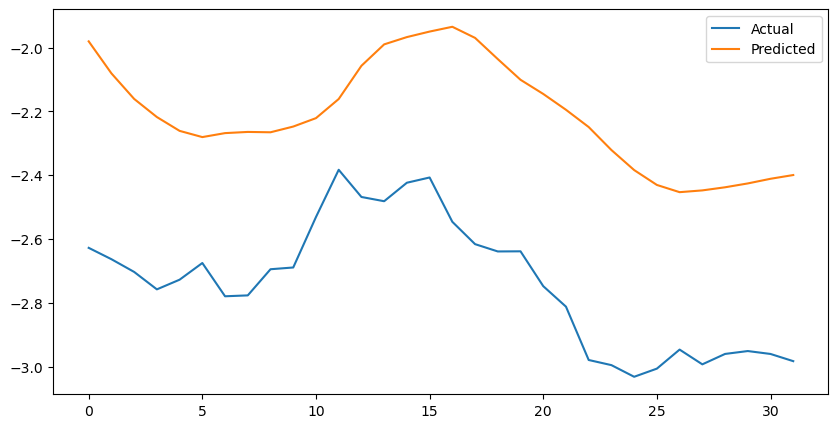

In [29]:
model2.eval()
with torch.no_grad():
    y_pred_test = model2(test_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor2.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()


In [30]:
mae = criterion(y_pred_test, test_labels_tensor2)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.28889620304107666


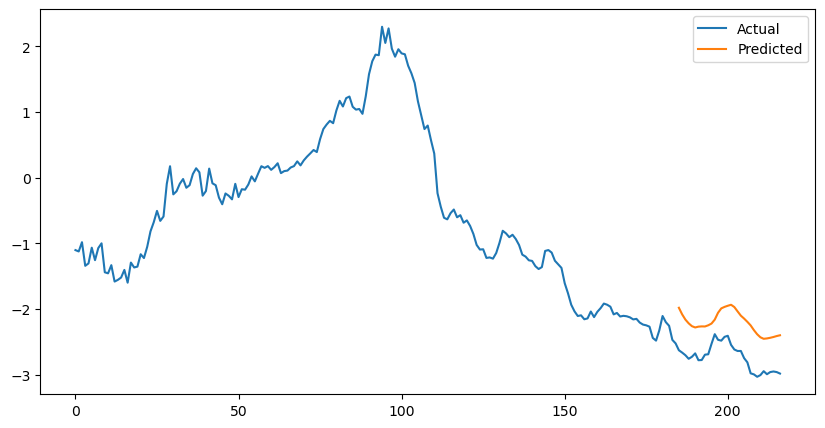

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(np.concatenate((train_df2, val_df2, test_df2), axis=0), label="Actual")
plt.plot(range(185, 217), y_pred_test.numpy(),label="Predicted")
plt.legend()
plt.show()

In [32]:
column_indices = {name: i for i, name in enumerate(third_piece.columns)}
n = len(third_piece)
train_df3 =third_piece[0:int(n*0.6)]
val_df3 = third_piece[int(n*0.6):int(n*0.8)]
test_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3
test_df3 = (test_df3 - train_mean3) / train_std3

train_seq3, train_labels3 = create_sequences(train_df3.values, 12)
val_seq3, val_labels3 = create_sequences(val_df3.values, 12)
test_seq3, test_labels3 = create_sequences(test_df3.values, 12)
# Convert to PyTorch tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3)  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3) # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3)  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3)  # (batch, output_dim)
test_seq_tensor3 = torch.FloatTensor(test_seq3)  # (batch, seq_length, input_dim)
test_labels_tensor3 = torch.FloatTensor(test_labels3)  # (batch, output_dim)

In [33]:
# Model parameters
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1

# Instantiate model
model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model3 = model3.to("cpu")  # Use "cuda" if you have a GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model3.parameters(), lr=0.01)

In [34]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model3.train()
    
    optimizer.zero_grad()
    y_pred = model3(train_seq_tensor3)
    
    loss = criterion(y_pred, train_label_tensor3)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Validation
    model3.eval()
    with torch.no_grad():
        y_val = model3(val_seq_tensor3)
        val_loss = criterion(y_val, val_label_tensor3)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.9228304624557495, Val Loss: 0.32514703273773193
Epoch 10, Train Loss: 0.2607707977294922, Val Loss: 0.19154293835163116
Epoch 20, Train Loss: 0.10773420333862305, Val Loss: 0.12464183568954468
Epoch 30, Train Loss: 0.07515916228294373, Val Loss: 0.12305473536252975
Epoch 40, Train Loss: 0.03677672892808914, Val Loss: 0.03870902210474014
Epoch 50, Train Loss: 0.02860848791897297, Val Loss: 0.01841660402715206
Epoch 60, Train Loss: 0.023540901020169258, Val Loss: 0.01443049218505621
Epoch 70, Train Loss: 0.02049115300178528, Val Loss: 0.012620928697288036
Epoch 80, Train Loss: 0.018635552376508713, Val Loss: 0.010773511603474617
Epoch 90, Train Loss: 0.017851846292614937, Val Loss: 0.009736289270222187


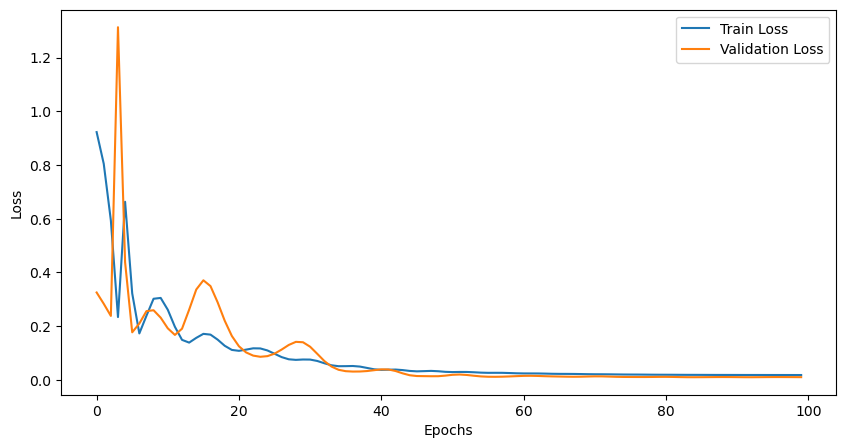

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


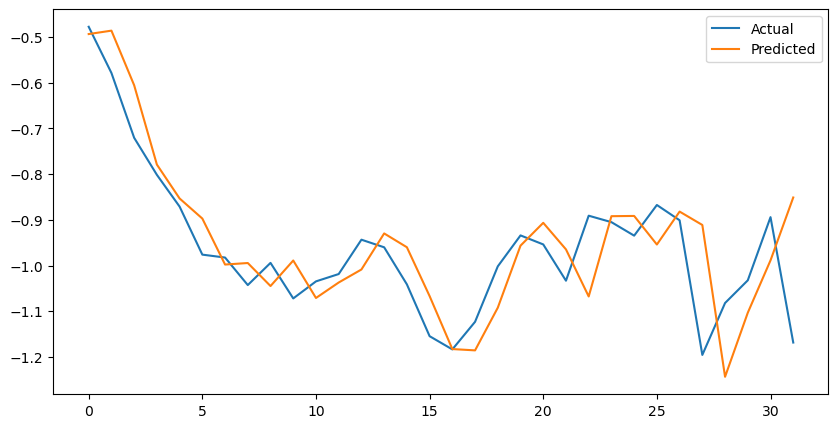

In [36]:
model3.eval()
with torch.no_grad():
    y_pred_test = model3(test_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor3.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()


In [37]:
mae = criterion(y_pred_test, test_labels_tensor3)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.010773712769150734


In [38]:
len(y_pred_test.numpy())

32

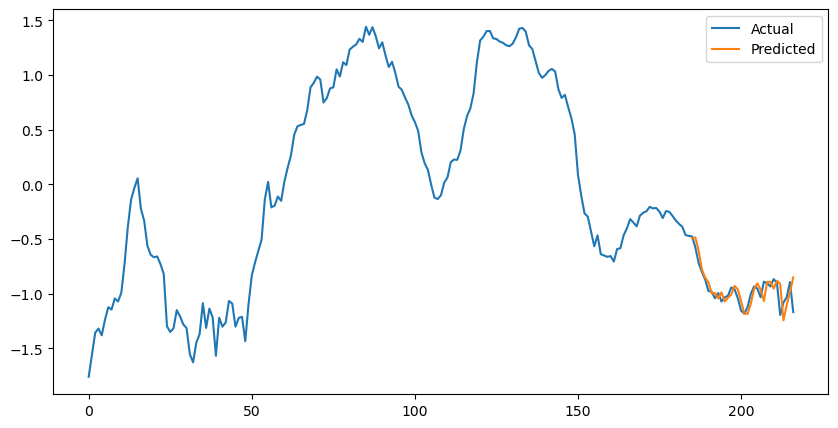

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(np.concatenate((train_df3, val_df3, test_df3), axis=0), label="Actual")
plt.plot(range(185, 217), y_pred_test.numpy(),label="Predicted")
plt.legend()
plt.show()

In [40]:
column_indices = {name: i for i, name in enumerate(second_piece.columns)}
n = len(fourth_piece)
train_df4 =fourth_piece[0:int(n*0.6)]
val_df4 = fourth_piece[int(n*0.6):int(n*0.8)]
test_df4 = fourth_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4
val_df4 = (val_df4 - train_mean4) / train_std4
test_df4 = (test_df4 - train_mean4) / train_std4

train_seq4, train_labels4 = create_sequences(train_df4.values, 12)
val_seq4, val_labels4 = create_sequences(val_df4.values, 12)
test_seq4, test_labels4 = create_sequences(test_df4.values, 12)
# Convert to PyTorch tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4)  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4) # (batch, output_dim)
val_seq_tensor4 = torch.FloatTensor(val_seq4)  # (batch, seq_length, input_dim)
val_label_tensor4 = torch.FloatTensor(val_labels4)  # (batch, output_dim)
test_seq_tensor4 = torch.FloatTensor(test_seq4)  # (batch, seq_length, input_dim)
test_labels_tensor4 = torch.FloatTensor(test_labels4)  # (batch, output_dim)

In [41]:
# Model parameters
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1

# Instantiate model
model4 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model4 = model4.to("cpu")  # Use "cuda" if you have a GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model4.parameters(), lr=0.01)

In [42]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model4.train()
    
    optimizer.zero_grad()
    y_pred = model4(train_seq_tensor4)
    
    loss = criterion(y_pred, train_label_tensor4)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Validation
    model3.eval()
    with torch.no_grad():
        y_val = model4(val_seq_tensor4)
        val_loss = criterion(y_val, val_label_tensor4)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.6347250938415527, Val Loss: 2.6506924629211426
Epoch 10, Train Loss: 0.1315341591835022, Val Loss: 0.7803522348403931
Epoch 20, Train Loss: 0.04753376543521881, Val Loss: 0.3322986364364624
Epoch 30, Train Loss: 0.02438245713710785, Val Loss: 0.16783063113689423
Epoch 40, Train Loss: 0.017924834042787552, Val Loss: 0.05229955539107323
Epoch 50, Train Loss: 0.016568901017308235, Val Loss: 0.025703294202685356
Epoch 60, Train Loss: 0.015116007067263126, Val Loss: 0.0407818928360939
Epoch 70, Train Loss: 0.01423059031367302, Val Loss: 0.050476256757974625
Epoch 80, Train Loss: 0.013435740023851395, Val Loss: 0.04441756010055542
Epoch 90, Train Loss: 0.012522783130407333, Val Loss: 0.048540495336055756


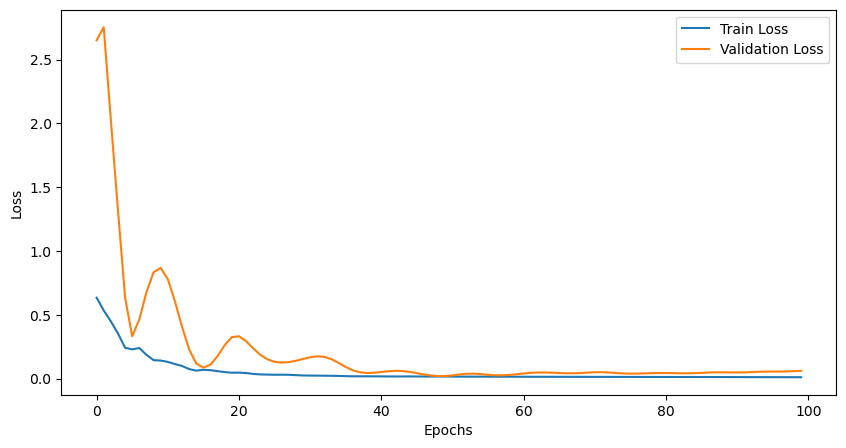

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


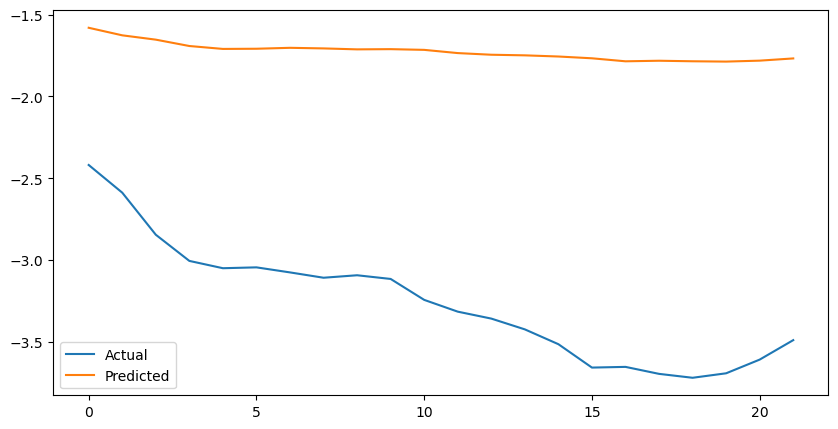

In [44]:
model4.eval()
with torch.no_grad():
    y_pred_test = model4(test_seq_tensor4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor4.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()


In [45]:
mae = criterion(y_pred_test, test_labels_tensor4)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 2.445570230484009


In [46]:
len(y_pred_test.numpy())

22

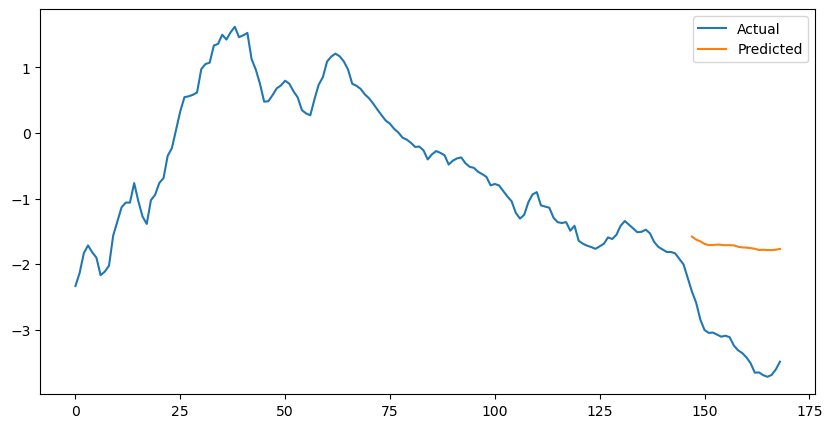

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(np.concatenate((train_df4, val_df4, test_df4), axis=0), label="Actual")
plt.plot(range(147, 169), y_pred_test.numpy(),label="Predicted")
plt.legend()
plt.show()

### Model 1 on other 3 pieces

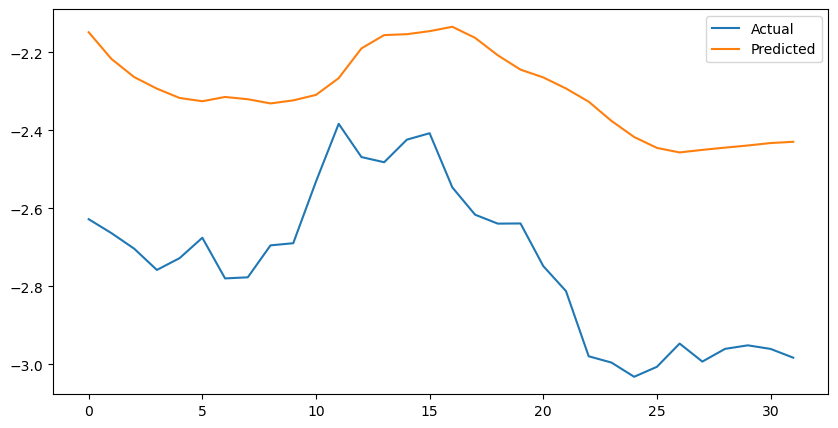

In [48]:
model1.eval()
with torch.no_grad():
    y_pred_test = model1(test_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor2.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()


In [49]:
mae = criterion(y_pred_test, test_labels_tensor2)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.20567144453525543


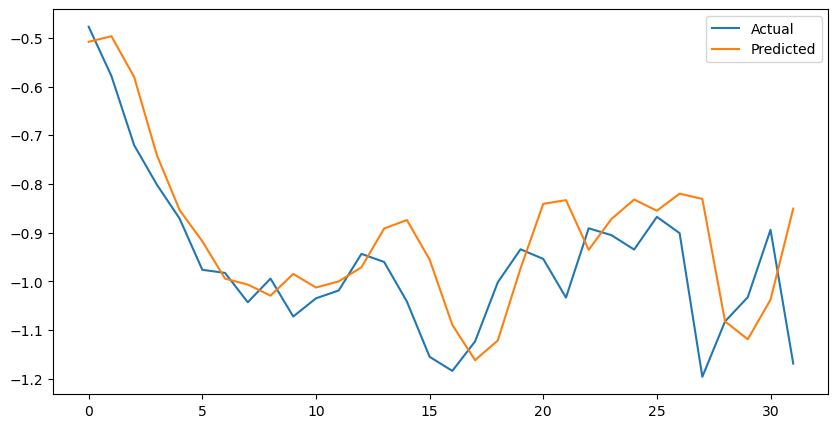

In [50]:
model1.eval()
with torch.no_grad():
    y_pred_test = model1(test_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor3.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [51]:
mae = criterion(y_pred_test, test_labels_tensor3)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.01502559520304203


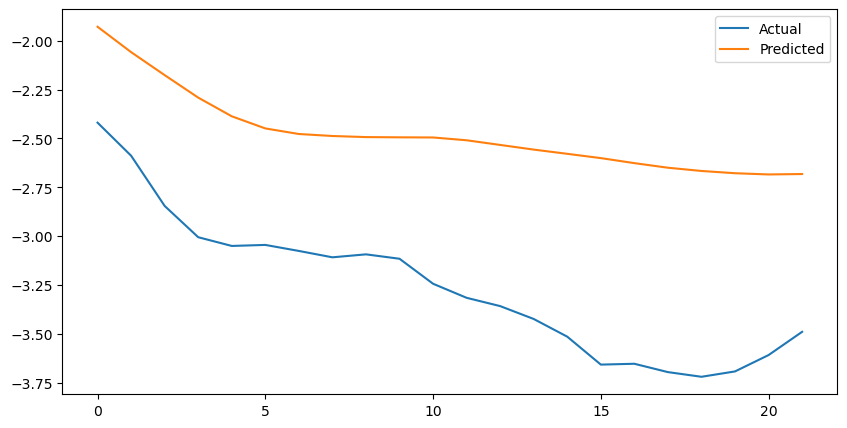

In [52]:
model1.eval()
with torch.no_grad():
    y_pred_test = model1(test_seq_tensor4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor4.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [53]:
mae = criterion(y_pred_test, test_labels_tensor4)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.6451860070228577


### Model 2 on 3 other pieces

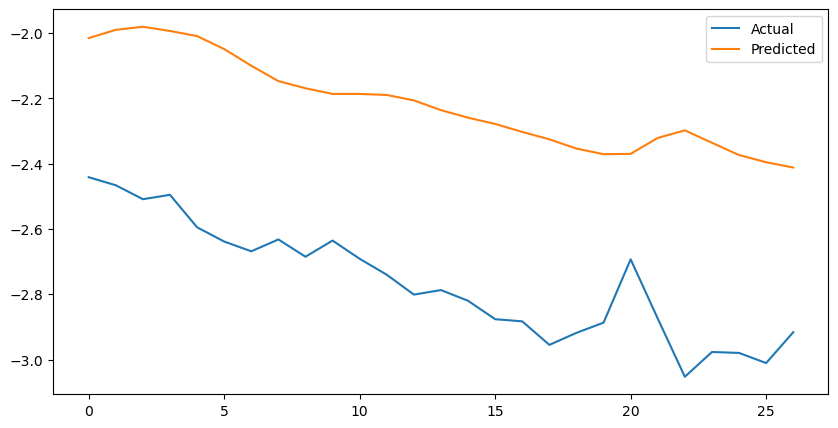

In [54]:
model2.eval()
with torch.no_grad():
    y_pred_test = model2(test_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor1.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [55]:
mae = criterion(y_pred_test, test_labels_tensor1)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.3053828775882721


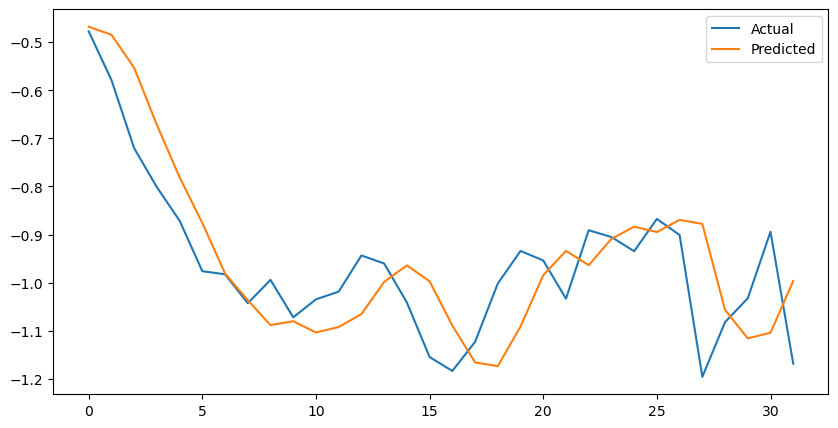

In [56]:
model2.eval()
with torch.no_grad():
    y_pred_test = model2(test_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor3.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [57]:
mae = criterion(y_pred_test, test_labels_tensor3)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.01268201507627964


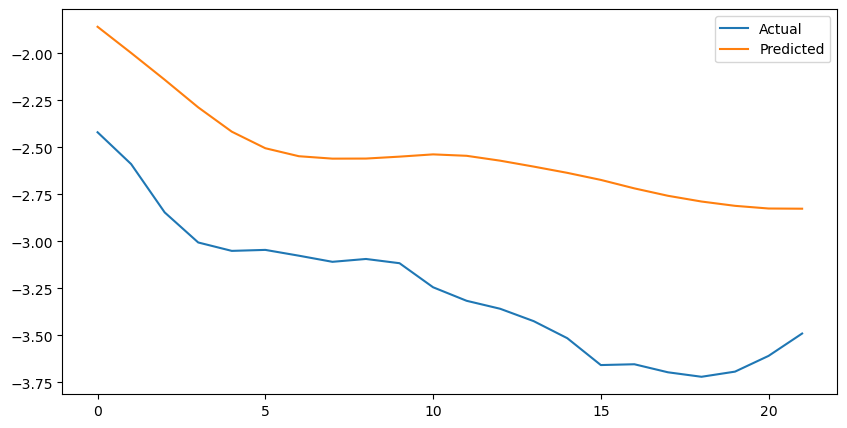

In [58]:
model2.eval()
with torch.no_grad():
    y_pred_test = model2(test_seq_tensor4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor4.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [59]:
mae = criterion(y_pred_test, test_labels_tensor4)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.5522815585136414


### Model 3 on other pieces

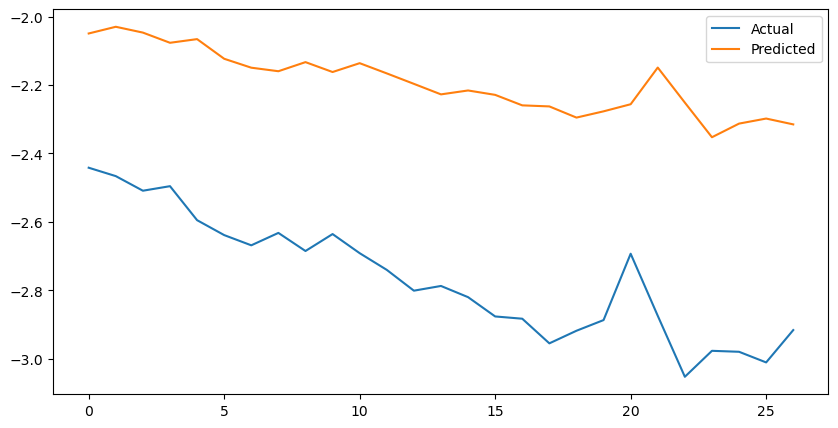

In [60]:
model3.eval()
with torch.no_grad():
    y_pred_test = model3(test_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor1.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [61]:
mae = criterion(y_pred_test, test_labels_tensor1)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.3367502987384796


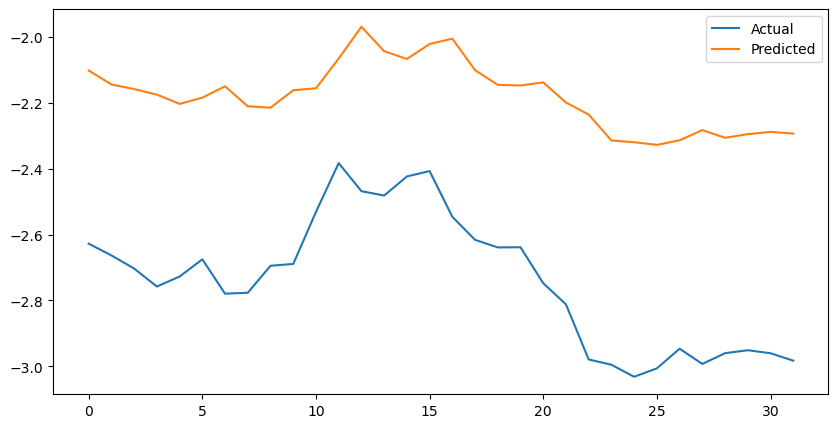

In [62]:
model3.eval()
with torch.no_grad():
    y_pred_test = model3(test_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor2.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [63]:
mae = criterion(y_pred_test, test_labels_tensor2)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.32310259342193604


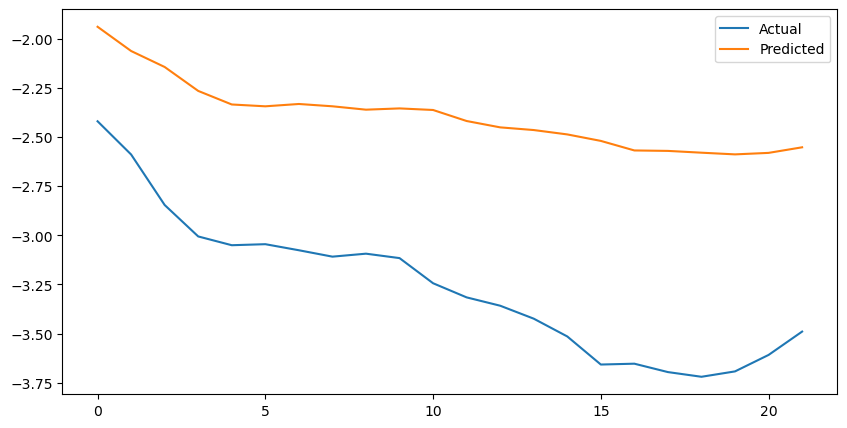

In [64]:
model3.eval()
with torch.no_grad():
    y_pred_test = model3(test_seq_tensor4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor4.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [65]:
mae = criterion(y_pred_test, test_labels_tensor4)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.7908201813697815


### Model 4 on other 3 pieces

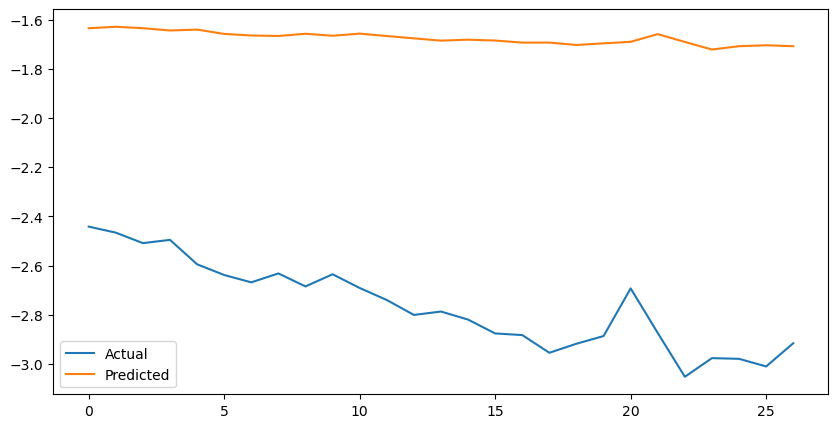

In [66]:
model4.eval()
with torch.no_grad():
    y_pred_test = model4(test_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor1.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [67]:
mae = criterion(y_pred_test, test_labels_tensor1)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 1.2105238437652588


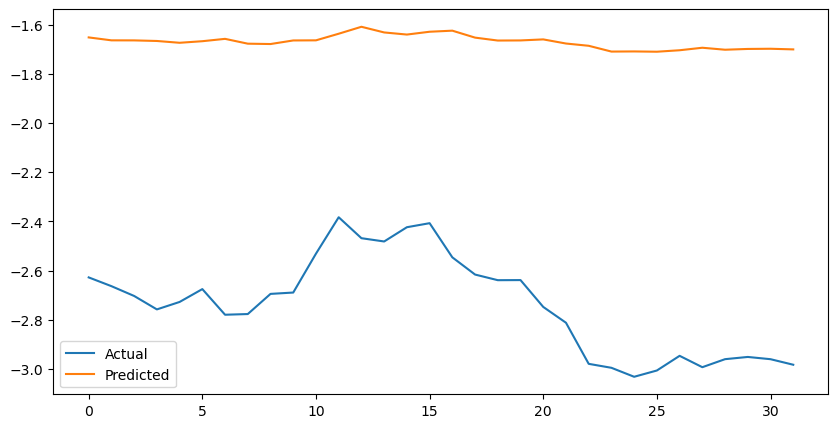

In [68]:
model4.eval()
with torch.no_grad():
    y_pred_test = model4(test_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor2.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [69]:
mae = criterion(y_pred_test, test_labels_tensor2)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 1.1686007976531982


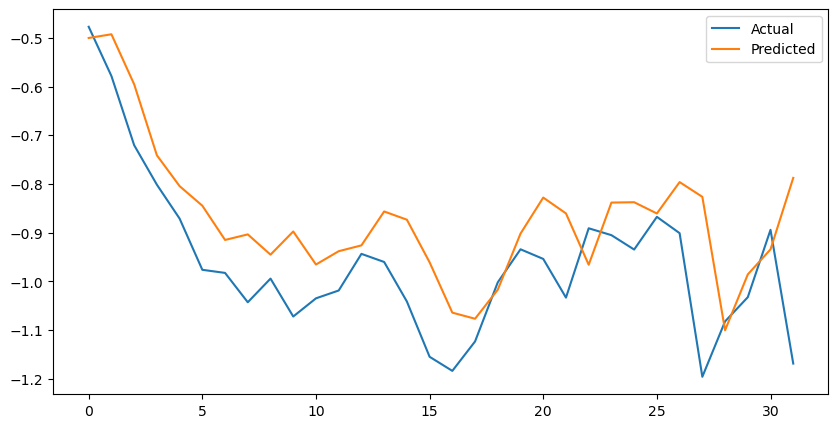

In [70]:
model4.eval()
with torch.no_grad():
    y_pred_test = model4(test_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor3.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [71]:
mae = criterion(y_pred_test, test_labels_tensor3)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.01792500913143158


In [72]:
import copy

### Now let's average all the models

In [73]:
average_model = copy.deepcopy(model1)
models = [model1, model2, model3, model4]
# Compute the average of the parameters
with torch.no_grad():
    for params in zip(*[model.parameters() for model in models]):  # Iterate over corresponding parameters
        avg_param = sum(params) / len(models)  # Element-wise average
        params[0].copy_(avg_param)  # Assign averaged value to the first model (used as reference)

# The `average_model` now has the averaged parameters

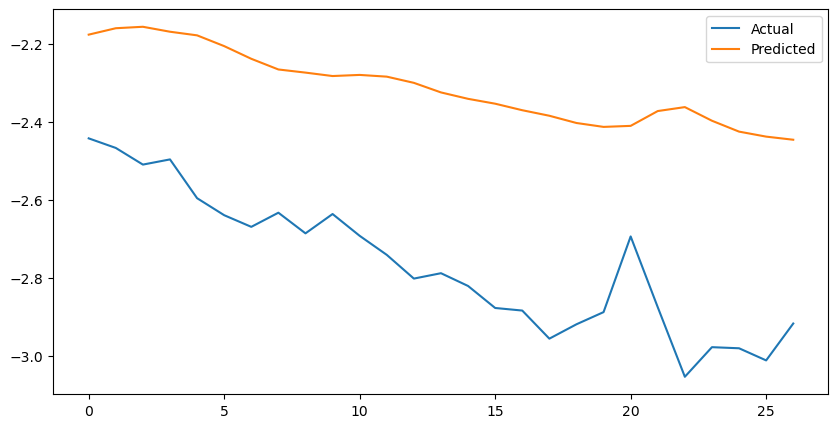

In [74]:
average_model.eval()
with torch.no_grad():
    y_pred_test = average_model(test_seq_tensor1)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor1.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [75]:
mae = criterion(y_pred_test, test_labels_tensor1)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.2151530534029007


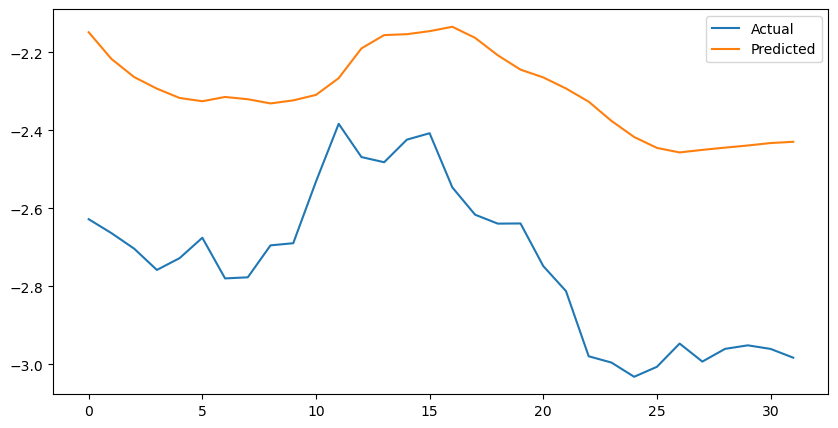

In [76]:
average_model.eval()
with torch.no_grad():
    y_pred_test = average_model(test_seq_tensor2)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor2.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [77]:
mae = criterion(y_pred_test, test_labels_tensor2)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.20567144453525543


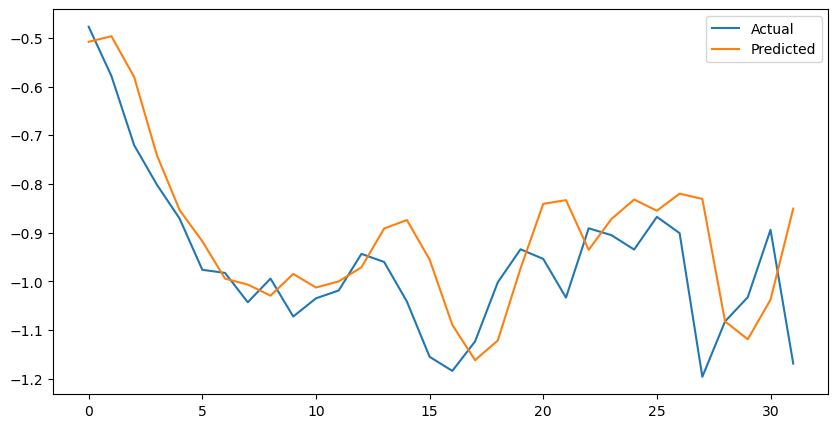

In [78]:
average_model.eval()
with torch.no_grad():
    y_pred_test = average_model(test_seq_tensor3)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor3.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [79]:
mae = criterion(y_pred_test, test_labels_tensor3)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.01502559520304203


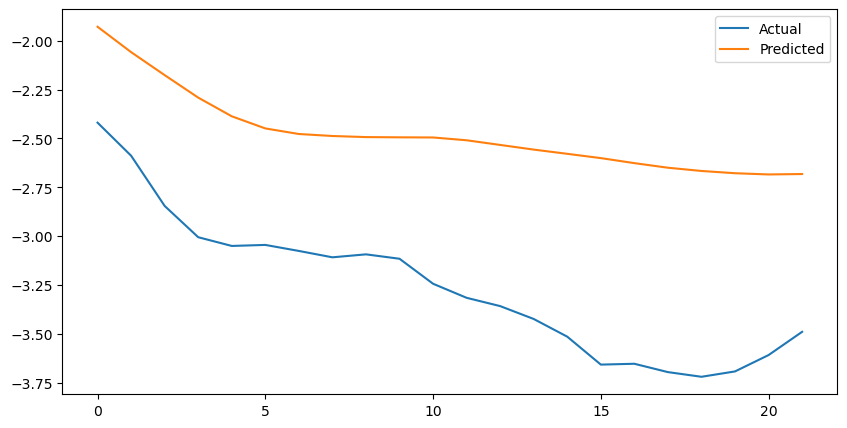

In [80]:
average_model.eval()
with torch.no_grad():
    y_pred_test = average_model(test_seq_tensor4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_labels_tensor4.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.show()

In [81]:
mae = criterion(y_pred_test, test_labels_tensor4)
print(f'Mean Absolute Error: {mae.item()}')

Mean Absolute Error: 0.6451860070228577
